In [1]:
import os
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import issparse, csr
import scanpy as sc

import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
from torch.utils.data import DataLoader

from anndata import AnnData
import anndata as ad
import scanpy as sc
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler

import math
from glob import glob

import warnings

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import random
seed = 666
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
## 读取数据
adata = sc.read_h5ad('../../shiya_integration/adata_ETPs.h5ad')  #Load cell line dataset(-> count data). 
adata
# celltype = adata.obs['celltype']

AnnData object with n_obs × n_vars = 4497 × 36972
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ori_stim', 'stim', 'percent.mt', 'integrated_snn_res.0.8', 'seurat_clusters', 'predicted.celltype.score', 'predicted.celltype', 'celltype', 'RNA_snn_res.0.8', 'integrated_snn_res.0.9', 'RNA_snn_res.0.9', 'RNA_snn_res.0.5', 'barcode', 'nCount_integrated', 'nFeature_integrated', 'nCount_prediction.score.celltype', 'nFeature_prediction.score.celltype', 'leiden_cluster', 'tissue', 'umap1', 'umap2', 'RNA_snn_res.0.3', 'clus', 'newtype', 'type_stim', 'T_type', 'Migratory_Score1', 'batch'
    var: 'gene'

In [4]:
adata.obs['batch'].value_counts()

batch
ETP    3220
TSP    1277
Name: count, dtype: int64

In [5]:
# 获取每个批次的细胞类型计数
celltype_counts = pd.crosstab(adata.obs['batch'], adata.obs['T_type'])

# 显示计数结果
print(celltype_counts)

T_type  TSP_BM  TSP_mPB  TSP_PB  TSP_SP  ETP1  ETP2  ETP3
batch                                                    
ETP          0        0       0       0  1594   843   783
TSP       1212       34      16      15     0     0     0


In [6]:
# 检查数据类型，此数据集是log1p数据
print(f"{adata.X.min()}\n{adata.X.max()}") 
# source_adata.to_df()

0.0
1196.0


In [7]:
# 非并行方式
from ccvae.step1_partition import run_partition

import time
start_time = time.time()
batch_key = 'batch'  # 批次信息保存在 adata.obs['batch'] 列中
num_iterations = 1 # number of re-sampling 
ccPairs_adata, rest_adata = run_partition(adata, batch_key, num_iterations,
                                          sample_ratio=1, drop_last=True, omics='scRNA',
                                          nHVGs=2000, npcs=20, singular_ratio=0.8, canonical_ratio=0.8, 
                                          metric='euclidean', k1=35, k2=10, 
                                          normalization=True, min_genes=200, min_cells=3,
                                          Matchability=False, seed = seed, verbose=False)
print("Running time is ", (time.time()-start_time)/60)

/home/zhouwg/data/software/anaconda3/envs/PyTorch_study/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preparing to calculating Anchor and Query Pairs...
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Finishing calculating cell-cell Pairs...
Running time is  1.631353227297465


### Run  ccVAE with HVGs

In [9]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [10]:
condition_key = 'batch'
cell_type_key = 'T_type'

ccvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Prepare data for ccVAE model

In [11]:
from ccvae.step2_ccVAE_utils import prepare_adata
source_adata,target_adata, source_conditions = prepare_adata(ccPairs_adata, rest_adata, n_top_genes=2000, condition_key=condition_key,
                                                             filter_min_counts=True, scale_factor=True, use_scale=False, 
                                                             use_logtrans=True, counts_per_cell=True, select_gene_adclust=True,
                                                             select_gene_desc=False, use_count=False)

### MSE loss

In [14]:
from ccvae.step2_run_ccVAE import CCVAE
### Create TRVAE model and train it on reference dataset
ccvae = CCVAE(
    adata_ccPairs=source_adata,
    adata_rest=target_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    #cell_type_key=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim = 20,
    recon_loss=['mse','mse'],
    mmd_on = 'z',
)


INITIALIZING THE WHOLE CCVAE NETWORK..............

Initializing ccVAE SubNetwork(trVAE) for ccPairs cells:
Encoder Sub-Architecture of ccPairs cells:
	Input Layer in, out and cond: 3448 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 20

Decoder Sub-Architecture of ccPairs cells:
	First Layer in, out and cond:  20 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3448 


Initializing ccVAE SubNetwork(CVAE) for batch-free cells:
Encoder Sub-Architecture of rest cells:
	Input Layer in, out and cond: 3448 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 20

Decoder Sub-Architecture of rest cells:
	First Layer in, out and cond:  20 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3448 



In [15]:
ccvae.train(
    n_epochs=ccvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    monitor_only_val = False,
    #train_frac = 0.8
)

Preparing (476, 3448) for ccPairs cells
Instantiating dataset of ccPairs cells
Preparing (4021, 3448) for rest cells
Instantiating dataset of rest cells
 |██------------------| 10.2%  - epoch_loss: 224.1890678406 - epoch_recon_loss: 110.5799026489 - epoch_kl_loss: 9.9908728600 - epoch_ccPairs_loss: 37.5992074013 - epoch_rest_loss: 72.9806919098 - epoch_mmd_loss: 0.5315451622 - val_loss: 278.4718017578 - val_recon_loss: 137.3109588623 - val_kl_loss: 10.3466987610 - val_ccPairs_loss: 31.9420986176 - val_rest_loss: 105.3688507080 - val_mmd_loss: 1.263244628900
ADJUSTED LR
 |██------------------| 13.0%  - epoch_loss: 213.4849739075 - epoch_recon_loss: 104.8645019531 - epoch_kl_loss: 9.8956334591 - epoch_ccPairs_loss: 35.1747536659 - epoch_rest_loss: 69.6897525787 - epoch_mmd_loss: 0.5893678665 - val_loss: 297.8721313477 - val_recon_loss: 146.6294860840 - val_kl_loss: 9.6274757385 - val_ccPairs_loss: 31.3478622437 - val_rest_loss: 115.2816314697 - val_mmd_loss: 1.532335281485
ADJUSTED LR
 |

In [16]:
from ccvae.step3_ccVAE_evaluation import CCVAE_EVAL

### Create anndata file of latent representation and compute UMAP
adata_latent = sc.AnnData(ccvae.get_latent())

ccVAE_eval = CCVAE_EVAL(adata_latent=adata_latent,
                       adata_ccPairs=source_adata,
                       adata_rest=target_adata,
                       condition_key=condition_key,
                       cell_type_key=cell_type_key,
                       n_neighbors=8)

/home/zhouwg/data/software/anaconda3/envs/PyTorch_study/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zhouwg/data/software/anaconda3/envs/PyTorch_study/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zhouwg/data/software/ana

In [18]:
## 新建文件夹
outdir = '../../shiya_integration/'
method = 'ccVAE_'
os.makedirs(outdir, exist_ok=True)

In [19]:
## 保存 latent 数据
ccVAE_eval.adata_latent.write(outdir+method+'adata_latent.h5ad', compression='gzip') 

In [20]:
## 保存 X + latent 数据
import anndata as ad

# Concatenate the two AnnData objects
merged_adata = ad.concat([source_adata, target_adata], join='outer')
merged_adata.obsm = ccVAE_eval.adata_latent.obsm.copy()

In [21]:
## 保存数据
merged_adata.obsm['X_ccvae'] = ccVAE_eval.adata_latent.X
merged_adata.write(outdir+method+'adata.h5ad', compression='gzip') 

In [22]:
## 保存模型
surg_path = 'model'
ccvae.save(outdir+method+surg_path, overwrite=True)

### Visualization of ccVAE results

In [6]:
import matplotlib.pyplot as plt

def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf')

In [7]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns          
            
def embedding(
        adata, 
        color='celltype', 
        color_map=None, 
        groupby='batch', 
        groups=None, 
        cond2=None, 
        v2=None, 
        save=None, 
        legend_loc='right margin', 
        legend_fontsize=None, 
        legend_fontweight='bold', 
        sep='_', 
        basis='X_umap',
        size=10,
        show=True,
    ):
    """
    plot separated embeddings with others as background
    
    Parameters
    ----------
    adata
        AnnData
    color
        meta information to be shown
    color_map
        specific color map
    groupby
        condition which is based-on to separate
    groups
        specific groups to be shown
    cond2
        another targeted condition
    v2
        another targeted values of another condition
    basis
        embeddings used to visualize, default is X_umap for UMAP
    size
        dot size on the embedding
    """
    
    if groups is None:
        groups = adata.obs[groupby].cat.categories
    for b in groups:
        adata.obs['tmp'] = adata.obs[color].astype(str)
        adata.obs['tmp'][adata.obs[groupby]!=b] = ''
        if cond2 is not None:
            adata.obs['tmp'][adata.obs[cond2]!=v2] = ''
            groups = list(adata[(adata.obs[groupby]==b) & 
                                (adata.obs[cond2]==v2)].obs[color].astype('category').cat.categories.values)
            size = min(size, 120000/len(adata[(adata.obs[groupby]==b) & (adata.obs[cond2]==v2)]))
        else:
            groups = list(adata[adata.obs[groupby]==b].obs[color].astype('category').cat.categories.values)
            size = min(size, 120000/len(adata[adata.obs[groupby]==b]))
        adata.obs['tmp'] = adata.obs['tmp'].astype('category')
        if color_map is not None:
            palette = [color_map[i] if i in color_map else 'gray' for i in adata.obs['tmp'].cat.categories]
        else:
            palette = None

        title = b if cond2 is None else v2+sep+b
        if save is not None:
            save_ = '_'+b+save
            show = False
        else:
            save_ = None
            show = True
        sc.pl.embedding(adata, color='tmp', basis=basis, groups=groups, title=title, palette=palette, size=size, save=save_,
                   legend_loc=legend_loc, legend_fontsize=legend_fontsize, legend_fontweight=legend_fontweight, show=show)
        del adata.obs['tmp']
        del adata.uns['tmp_colors']

In [3]:
## 新建文件夹
outdir = '../../shiya_integration/'
method = 'ccVAE_'
os.makedirs(outdir, exist_ok=True)

merged_adata = sc.read_h5ad(outdir+method+'adata.h5ad')
merged_adata

AnnData object with n_obs × n_vars = 4497 × 3448
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ori_stim', 'stim', 'percent.mt', 'integrated_snn_res.0.8', 'seurat_clusters', 'predicted.celltype.score', 'predicted.celltype', 'celltype', 'RNA_snn_res.0.8', 'integrated_snn_res.0.9', 'RNA_snn_res.0.9', 'RNA_snn_res.0.5', 'barcode', 'nCount_integrated', 'nFeature_integrated', 'nCount_prediction.score.celltype', 'nFeature_prediction.score.celltype', 'leiden_cluster', 'tissue', 'umap1', 'umap2', 'RNA_snn_res.0.3', 'clus', 'newtype', 'type_stim', 'T_type', 'Migratory_Score1', 'batch', 'n_genes', 'n_counts', 'scale_factor'
    obsm: 'X_ccvae', 'X_umap'

In [4]:
# 先计算细胞之间的距离矩阵，然后计算邻接矩阵（图），UMAP分析需要以此作为输入
sc.pp.neighbors(merged_adata, use_rep='X_ccvae')
sc.tl.umap(merged_adata)
sc.tl.leiden(merged_adata, resolution=0.8) #默认分辨率为1，调整分辨率可以影响cluster数量
merged_adata

/home/zhouwg/data/software/anaconda3/envs/PyTorch_study/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zhouwg/data/software/anaconda3/envs/PyTorch_study/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zhouwg/data/software/ana

AnnData object with n_obs × n_vars = 4497 × 3448
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ori_stim', 'stim', 'percent.mt', 'integrated_snn_res.0.8', 'seurat_clusters', 'predicted.celltype.score', 'predicted.celltype', 'celltype', 'RNA_snn_res.0.8', 'integrated_snn_res.0.9', 'RNA_snn_res.0.9', 'RNA_snn_res.0.5', 'barcode', 'nCount_integrated', 'nFeature_integrated', 'nCount_prediction.score.celltype', 'nFeature_prediction.score.celltype', 'leiden_cluster', 'tissue', 'umap1', 'umap2', 'RNA_snn_res.0.3', 'clus', 'newtype', 'type_stim', 'T_type', 'Migratory_Score1', 'batch', 'n_genes', 'n_counts', 'scale_factor', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_ccvae', 'X_umap'
    obsp: 'distances', 'connectivities'

In [9]:
merged_adata.obs['T_type'].value_counts()

T_type
ETP1       1594
TSP_BM     1212
ETP2        843
ETP3        783
TSP_mPB      34
TSP_PB       16
TSP_SP       15
Name: count, dtype: int64

In [10]:
### 去除  TSP_SP  TSP_mPB 这个细胞类型 
merged_adata = merged_adata[~merged_adata.obs['T_type'].isin(['TSP_SP','TSP_mPB']),]
merged_adata.obs['T_type'].value_counts()

T_type
ETP1      1594
TSP_BM    1212
ETP2       843
ETP3       783
TSP_PB      16
Name: count, dtype: int64

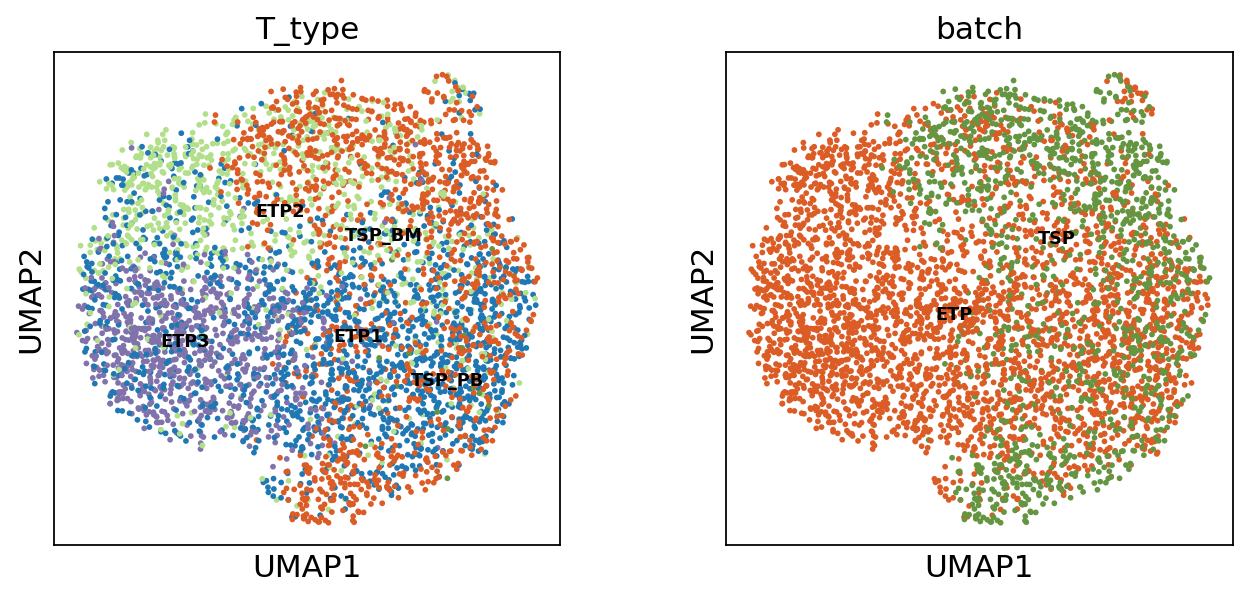

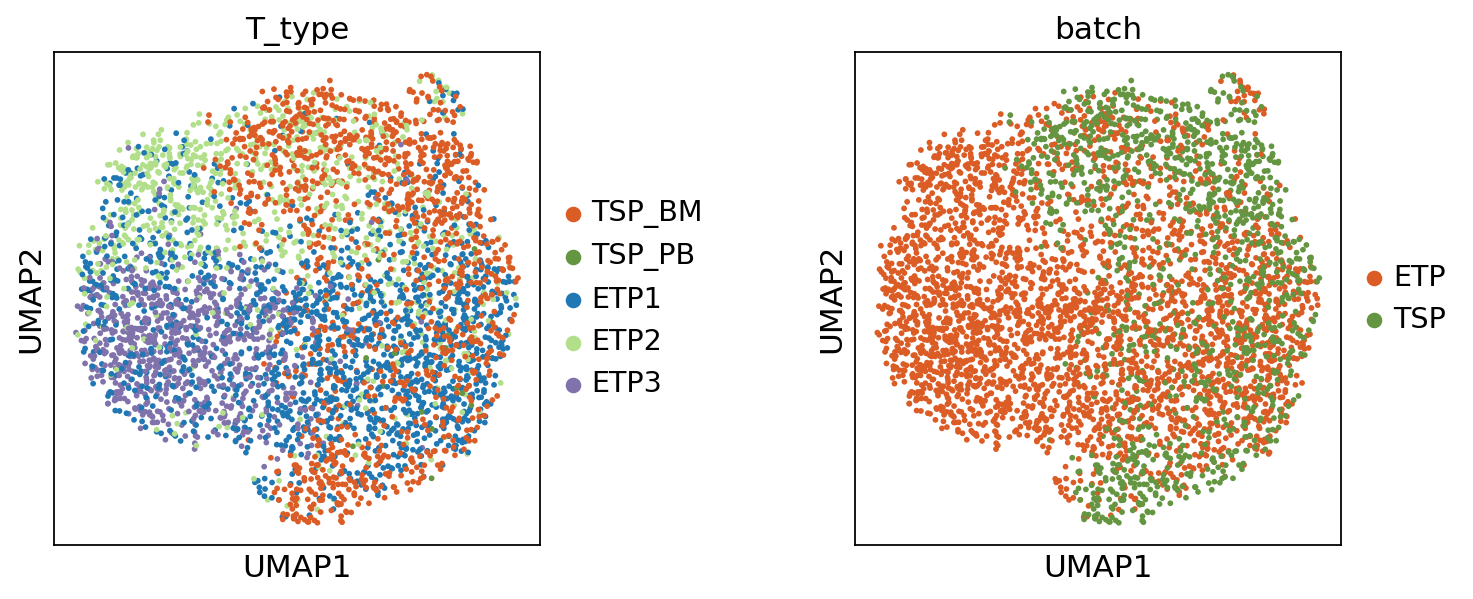

In [11]:
color = ["#DB5C25","#649541","#1F78B4","#B2DF8A","#8073AC"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.set_figure_params(figsize=(4, 4))

# plt.rcParams['figure.figsize'] = (4,4)
sc.pl.umap(merged_adata, color=['T_type', 'batch'], legend_loc='on data', palette=color,
           legend_fontsize=8, save='_dimplot_labelsON.pdf')


with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(merged_adata, color=['T_type', 'batch'],palette=color,
           wspace=0.5, ncols=2, save='_dimplot.pdf')

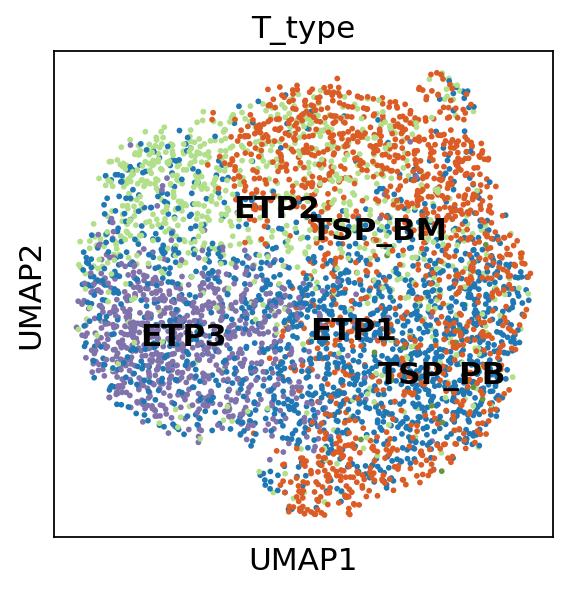

In [12]:
sc.pl.umap(merged_adata, color=['T_type'],palette=color, legend_loc='on data', save='_Ttypedimplot_labelsON.pdf')

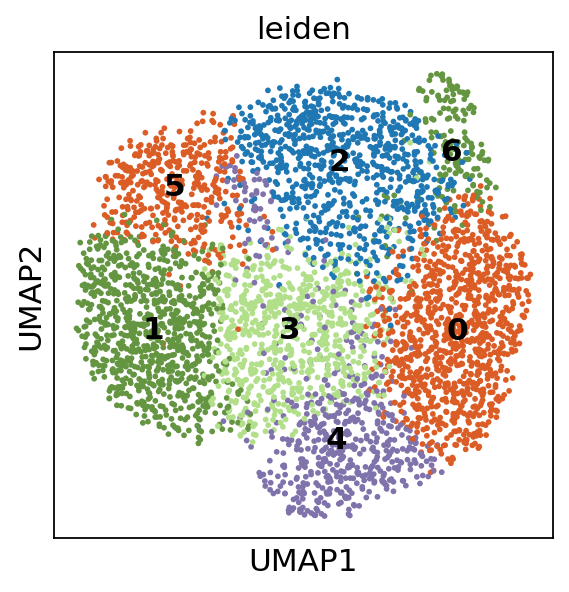

In [13]:
sc.pl.umap(merged_adata, color=['leiden'], palette=color, legend_loc="on data", save='_cluster_labelsON.pdf')

/tmp/ipykernel_155116/2403516663.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['tmp'][adata.obs[groupby]!=b] = ''


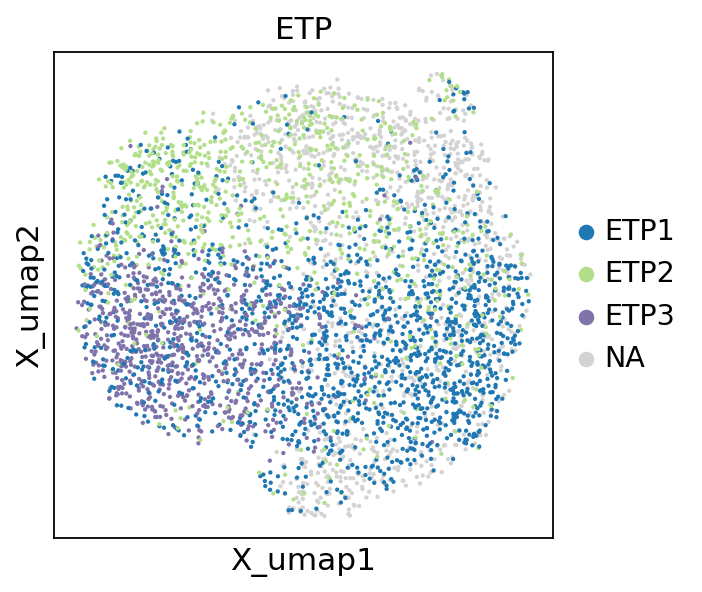

/tmp/ipykernel_155116/2403516663.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['tmp'][adata.obs[groupby]!=b] = ''


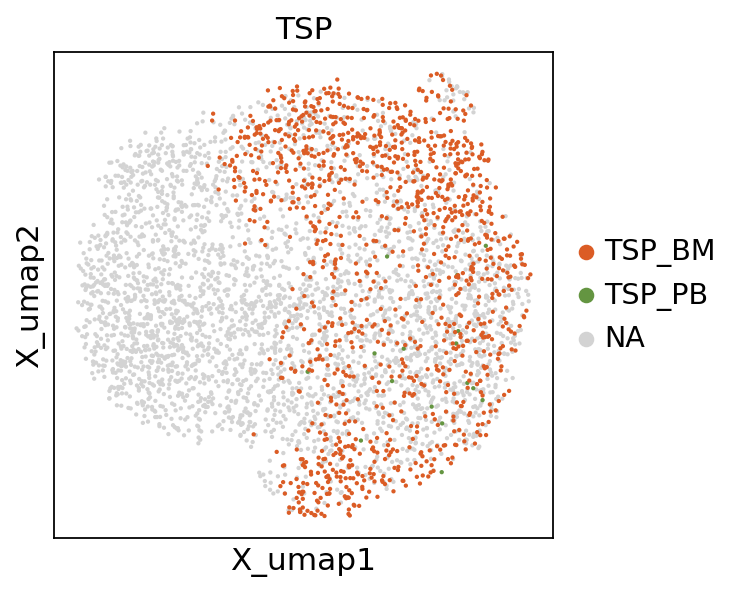

In [14]:
color_map = {
    'TSP_BM': "#DB5C25",
    #'TSP_mPB': "#F3B747",
    'TSP_PB': "#649541",
    #'TSP_SP': "#BC80BD",
    'ETP1': "#1F78B4",
    'ETP2': "#B2DF8A",
    'ETP3': "#8073AC"
}
embedding(merged_adata, 
        color='T_type', 
        color_map= color_map, 
        groupby='batch',size=15)

In [15]:
embedding(merged_adata, 
        color='T_type', 
        color_map= color_map, 
        groupby='batch',size=15, save='Dimplot_spilit.pdf')

/tmp/ipykernel_155116/2403516663.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['tmp'][adata.obs[groupby]!=b] = ''


/tmp/ipykernel_155116/2403516663.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['tmp'][adata.obs[groupby]!=b] = ''


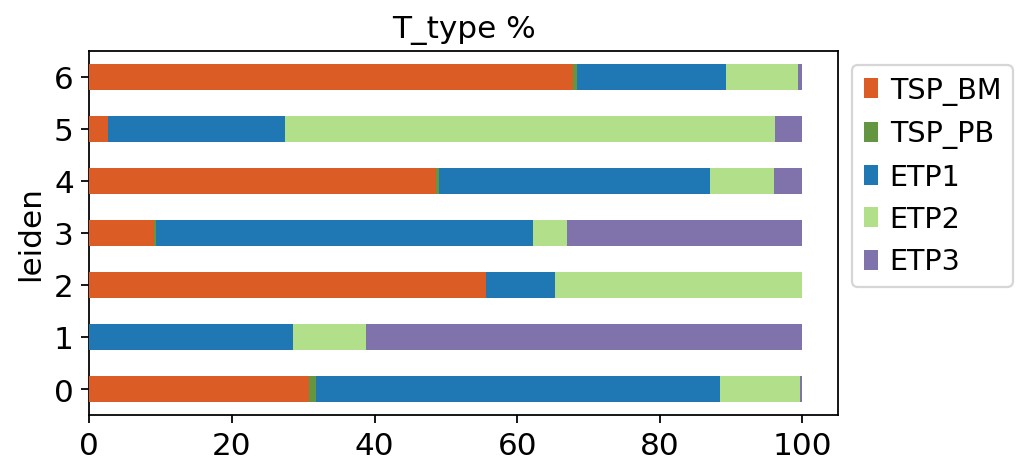

In [16]:
color = ["#DB5C25","#649541","#1F78B4","#B2DF8A","#8073AC"]
Barplot('T_type', merged_adata, var='leiden', color = color)

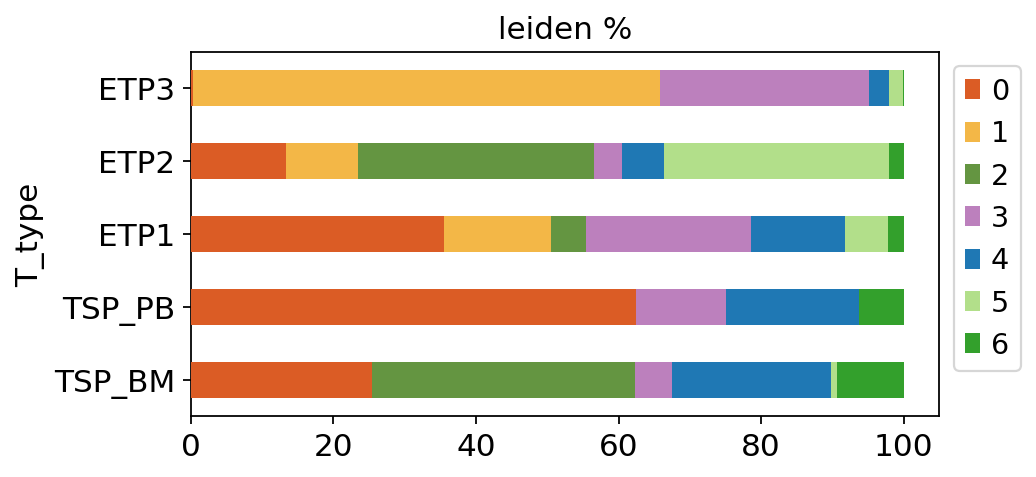

In [18]:
color = ["#DB5C25","#F3B747","#649541","#BC80BD","#1F78B4","#B2DF8A","#33A02C"]
Barplot('leiden', merged_adata, var='T_type', color = color)

In [19]:
# ## 保存数据
# merged_adata.write(outdir+method+'adata_celltype.h5ad', compression='gzip') 

In [20]:
# ## 保存模型
# surg_path = 'model'
# ccvae.save(outdir+method+surg_path, overwrite=True)